# **Traffic Classification using Deep Learning**

### Import useful libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import sklearn
import imblearn
from imblearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import MaxNorm
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling1D, Dense, Flatten, Dropout, Input, BatchNormalization, Reshape, LSTM
from tensorflow.keras.models import Model
import pprint as pprint

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

### Link gdrive


In [2]:
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Encode categorical features

In [3]:
features = np.load("./gdrive/MyDrive/8 pck/dataset_features_header.npy")
labels = np.load("./gdrive/MyDrive/8 pck/dataset_labels_header.npy")

In [4]:
classes = np.unique(labels)

### Train-test splitting

In [5]:
from sklearn.model_selection import train_test_split

samples_train, samples_test, categorical_labels_train, categorical_labels_test = \
    train_test_split(features,labels, shuffle=True, random_state=0, stratify=labels)

In [6]:
samples_test.shape

(216573, 8, 6)

In [7]:
from sklearn.preprocessing import QuantileTransformer

hdr_input_dim = (8,6)

scaler = QuantileTransformer()
for j in range(hdr_input_dim[0]):
    scaler.fit(samples_train[:, j, :])
    samples_train[:, j, :] = scaler.transform(samples_train[:, j, :])
    samples_test[:, j, :] = scaler.transform(samples_test[:, j, :])

In [8]:
samples_train = np.expand_dims(samples_train, axis=3)
samples_test = np.expand_dims(samples_test, axis=3)

In [9]:
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score


def evaluate(xtest, ytest, ypred, title):

  accuracy_score(ytest, ypred) #Accuracy

  macro_gmean = np.mean(geometric_mean_score(ytest, ypred, average=None))
  print('macro g-mean -> ' + str(macro_gmean))

  print(classification_report(ypred, ytest)) #Detailed metrics

  mat = confusion_matrix(ytest, ypred, normalize='true') #Confusion matrix seaborn
  plt.figure(figsize=(12, 8), dpi=70)
  ax = plt.subplot()
  sns.heatmap(mat.T*100, square=True, annot=True, vmin=0.0, vmax=100.0, 
              cbar=True, ax=ax, xticklabels=classes, yticklabels=classes, 
              linewidths=1,fmt='1.4f', annot_kws={"size":14}) 
  sns.set(font_scale=1.2) 
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title(title)

### Define DL CNN-based architecture

In [10]:
input_dim = 8
input_dim_2 = 6
num_classes = len(classes)

input = Input(shape=(input_dim, input_dim_2, 1), name='input')
cv1 = Conv2D(filters=32, kernel_size=(4, 2), strides=1, padding='valid', activation='elu')(input)
bn1 = BatchNormalization()(cv1)
cv2 = Conv2D(filters=64, kernel_size=(4, 2), strides=1, padding='valid', activation='elu')(bn1)
bn2 = BatchNormalization()(cv2)
shape_interm = bn2.shape
r1 = Reshape((shape_interm[2], shape_interm[3] * shape_interm[1]))(bn2)
lstm = LSTM(100)(r1)
d1 = Dropout(0.2)(lstm)
de1 = Dense(100, activation='elu')(d1)
d2 = Dropout(0.4)(de1)
de2 = Dense(num_classes, activation='softmax')(d2)

model = Model(inputs=input, outputs=de2, name='RNN_CNN')
model.summary()

Model: "RNN_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8, 6, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          288       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 32)          128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 4, 64)          16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 4, 64)          256       
_________________________________________________________________
reshape (Reshape)            (None, 4, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               9160

In [11]:
from tensorflow.keras.optimizers import Adam

adam_opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#adam_opt =  Adadelta(lr=0.0001, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

one_hot_categorical_labels_train = to_categorical(categorical_labels_train, num_classes=num_classes)

earlystop = EarlyStopping(monitor='accuracy', min_delta=0.01, patience=15, verbose=1, mode='auto')

model.fit(x=samples_train,
          y=one_hot_categorical_labels_train,
          epochs=60, 
          batch_size=32,
          callbacks=earlystop)

Epoch 1/60
20304/20304 [==============================] - 180s 7ms/step - loss: 0.4810 - accuracy: 0.8047
Epoch 2/60
20304/20304 [==============================] - 146s 7ms/step - loss: 0.3216 - accuracy: 0.8677
Epoch 3/60
20304/20304 [==============================] - 143s 7ms/step - loss: 0.2696 - accuracy: 0.8792
Epoch 4/60
20304/20304 [==============================] - 143s 7ms/step - loss: 0.2493 - accuracy: 0.8877
Epoch 5/60
20304/20304 [==============================] - 141s 7ms/step - loss: 0.2379 - accuracy: 0.8928
Epoch 6/60
20304/20304 [==============================] - 140s 7ms/step - loss: 0.2335 - accuracy: 0.8945
Epoch 7/60
20304/20304 [==============================] - 140s 7ms/step - loss: 0.2278 - accuracy: 0.8965
Epoch 8/60
20304/20304 [==============================] - 140s 7ms/step - loss: 0.2212 - accuracy: 0.8990
Epoch 9/60
20304/20304 [==============================] - 137s 7ms/step - loss: 0.2085 - accuracy: 0.9077
Epoch 10/60
20304/20304 [=====================

### Compute and show the confusion matrix

In [13]:
soft_values = model.predict(samples_test, verbose=2)
prediction_test = soft_values.argmax(axis=-1)

accuracy = sklearn.metrics.accuracy_score(categorical_labels_test, prediction_test)
fmeasure = sklearn.metrics.f1_score(categorical_labels_test, prediction_test, average='macro')
macro_gmean = np.mean(imblearn.metrics.geometric_mean_score(categorical_labels_test, prediction_test, average=None))
classification_report = sklearn.metrics.classification_report(categorical_labels_test, prediction_test)

print('Accuracy: {}'.format(accuracy))
print('Macro F-measure: {}'.format(fmeasure))
print('Macro G-mean: {}'.format(macro_gmean))
print(classification_report)

6768/6768 - 14s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9417979157143319
Macro F-measure: 0.5085935754541998
Macro G-mean: 0.5741391071235684
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     19174
           1       0.78      0.18      0.30      5498
           2       0.67      0.15      0.25        13
           3       0.49      0.94      0.64      8418
           4       0.00      0.00      0.00       209
           5       0.75      1.00      0.86         3
           6       0.00      0.00      0.00         7
           7       1.00      1.00      1.00      9974
           8       0.00      0.00      0.00         4
           9       1.00      0.99      1.00     38119
          10       0.98      1.00      0.99    133596
          11       0.00      0.00      0.00       222
          12       0.77      0.80      0.79      1336

    accuracy                           0.94    216573
   macro avg       0.57      0.52      0.51    216573
weighted avg       0.95      0.94   

Text(0.5, 1.0, 'Confusion Matrix of LSTM Traffic Classifier in Log-scale')

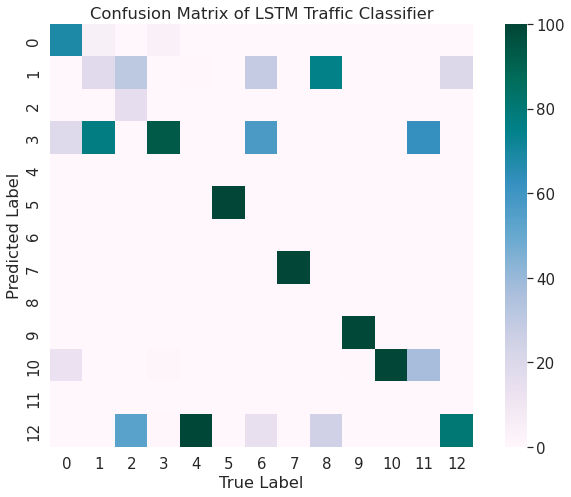

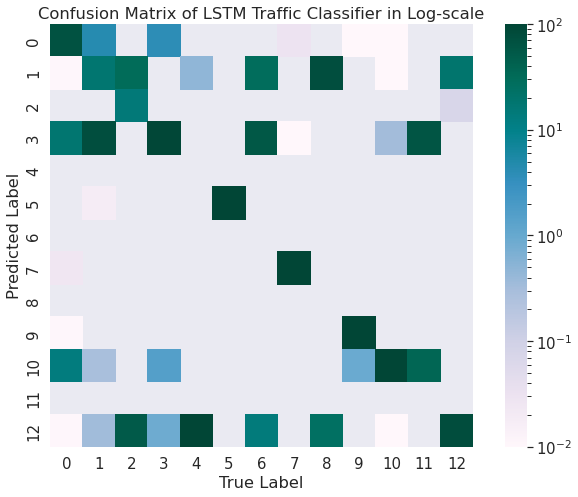

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

mat = confusion_matrix(categorical_labels_test, prediction_test, normalize = 'true')

plt.figure(figsize=(12, 8), dpi=70)
cmap = cm.get_cmap('PuBuGn')
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True,ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of LSTM Traffic Classifier')

plt.figure(figsize=(12, 8), dpi=70)
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True, norm=LogNorm(vmin=0.01, vmax=100.0),ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn in logscale
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of LSTM Traffic Classifier in Log-scale')